Install requirements

In [2]:
!pip install numpy pandas matplotlib seaborn opencv-python scikit-learn tensorflow -q

Imports

In [83]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2, VGG16, EfficientNetB0
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg16_preprocess
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow.keras.backend as K
import tensorflow as tf

Load data

In [5]:
def load_data(data_folder):
    images = []
    labels = []

    for split in ['Training', 'Testing']:
        split_folder = os.path.join(data_folder, split)
        if not os.path.exists(split_folder):
            print(f"Folder {split} does not exist!")
        for class_name in os.listdir(split_folder):
            class_path = os.path.join(split_folder, class_name)
            if not os.path.isdir(class_path):
                print(f"Folder {class_path} does not exist!")
            for img_file in os.listdir(class_path):
                if img_file.endswith(('.jpg', '.jpeg', '.png')):
                    img_path = os.path.join(class_path, img_file)
                    label = class_name.lower().replace('no_tumor', 'notumor').replace('_tumor', '')
                    images.append(img_path)
                    labels.append(label)
                    
    return images, labels

In [6]:
base_folder = os.path.join(os.getcwd(), "data")
dataset1 = os.path.join(base_folder, "brain-tumor-mri-dataset")
dataset2 = os.path.join(base_folder, "brain-tumor-classification-mri")

images1, labels1 = load_data(dataset1)
images2, labels2 = load_data(dataset2)

images = images1 + images2
labels = labels1 + labels2

Split the data

In [7]:
le = LabelEncoder()
labels_encoded = le.fit_transform(labels)

X_train, X_val, y_train, y_val = train_test_split(images, labels_encoded, test_size=0.2, stratify=labels_encoded, random_state=42)

Resize the images

In [32]:
IMG_SIZE = (224, 224)

def resize(img_paths):
    return np.array([cv2.resize(cv2.imread(path), IMG_SIZE) for path in img_paths])

X_train_resized = resize(X_train)
X_val_resized = resize(X_val)

y_train_cat = to_categorical(y_train, num_classes=4)
y_val_cat = to_categorical(y_val, num_classes=4)

Class mapping for standardization

In [33]:
name_map = {
    'glioma_tumor': 'glioma',
    'meningioma_tumor': 'meningioma',
    'pituitary_tumor': 'pituitary',
    'no_tumor': 'notumor',
    'glioma': 'glioma',
    'meningioma': 'meningioma',
    'pituitary': 'pituitary',
    'notumor': 'notumor'
}

Collect metadata from a dataset

In [34]:
def collect_dataset_info(base_path, dataset_name):
    data = []

    for split in ['Training', 'Testing']:
        split_path = os.path.join(base_path, split)
        
        if not os.path.exists(split_path):
            print(f"Folder {split} does not exist!")

        for class_folder in os.listdir(split_path):
            class_path = os.path.join(split_path, class_folder)
            if not os.path.isdir(class_path):
                print(f"Folder {class_folder} does not exist!")

            class_name = name_map.get(class_folder, class_folder)

            for img_file in os.listdir(class_path):
                if img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
                    img_path = os.path.join(class_path, img_file)
                    try:
                        with Image.open(img_path) as img:
                            width, height = img.size
                            mode = img.mode

                        data.append({
                            'dataset': dataset_name,
                            'split': split,
                            'class': class_name,
                            'image_name': img_file,
                            'path': img_path,
                            'width': width, 
                            'height': height,
                            'mode': mode
                        })
                    except Exception as e:
                        print(f"Error reading {img_path}: {e}")
                        
    return pd.DataFrame(data)

Load metadata from both datasets and merge them

In [35]:
df1 = collect_dataset_info(dataset1, "dataset1")
df2 = collect_dataset_info(dataset2, "dataset2")

df = pd.concat([df1, df2], ignore_index=True)

EDA (Exploratory Data Analysis)

In [36]:
print("Total images in merged dataset: ", len(df))
print(df.head())

Total images in merged dataset:  10287
    dataset     split       class    image_name  \
0  dataset1  Training  meningioma   m1(166).jpg   
1  dataset1  Training  meningioma  m3 (149).jpg   
2  dataset1  Training  meningioma   m2 (62).jpg   
3  dataset1  Training  meningioma   m1(129).jpg   
4  dataset1  Training  meningioma   m1(182).jpg   

                                                path  width  height mode  
0  /home/lateral/patricia/data/brain-tumor-mri-da...   1149    1019  RGB  
1  /home/lateral/patricia/data/brain-tumor-mri-da...    512     512  RGB  
2  /home/lateral/patricia/data/brain-tumor-mri-da...    512     512  RGB  
3  /home/lateral/patricia/data/brain-tumor-mri-da...    318     354  RGB  
4  /home/lateral/patricia/data/brain-tumor-mri-da...    200     236  RGB  


Class distribution by split

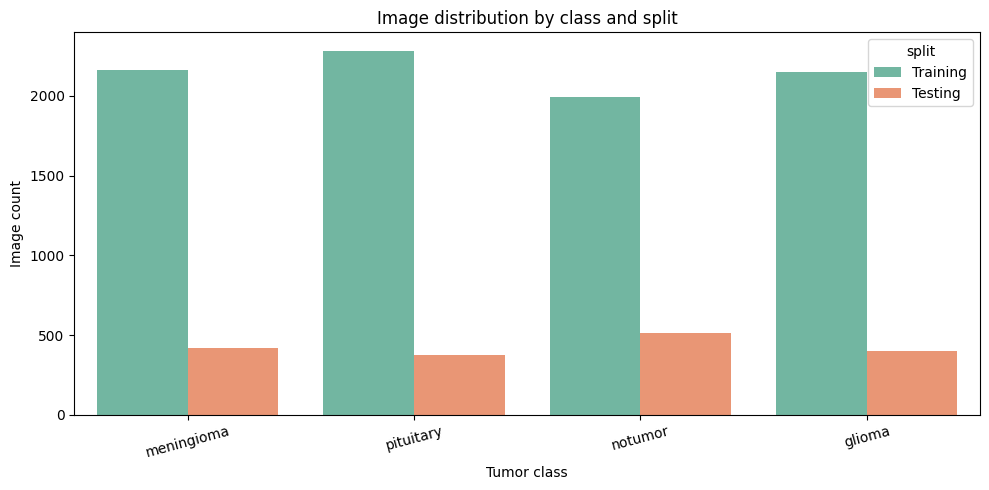

In [37]:
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='class', hue='split', palette='Set2')
plt.title("Image distribution by class and split")
plt.xticks(rotation=15)
plt.xlabel("Tumor class")
plt.ylabel("Image count")
plt.tight_layout()
plt.show()

Image size distributions

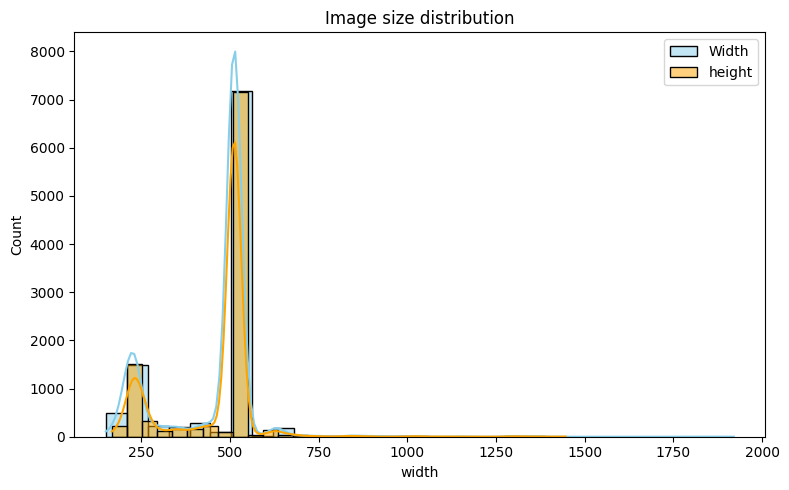

In [38]:
plt.figure(figsize=(8, 5))
sns.histplot(df['width'], bins=30, color='skyblue', label='Width', kde=True)
sns.histplot(df['height'], bins=30, color='orange', label='height', kde=True)
plt.legend()
plt.title("Image size distribution")
plt.tight_layout()
plt.show()

Image examples

In [39]:
def show_sample(sf, split):
    classes = df['class'].unique()
    plt.figure(figsize=(15, 8))

    for i, cls in enumerate(classes):
        sample = df[(df['class'] == cls) & (df['split'] == split)].iloc[0]
        img = Image.open(sample['path'])
        plt.subplot(2, len(classes)//2 + 1, i + 1)
        plt.imshow(img)
        plt.title(f"{split}: {cls}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

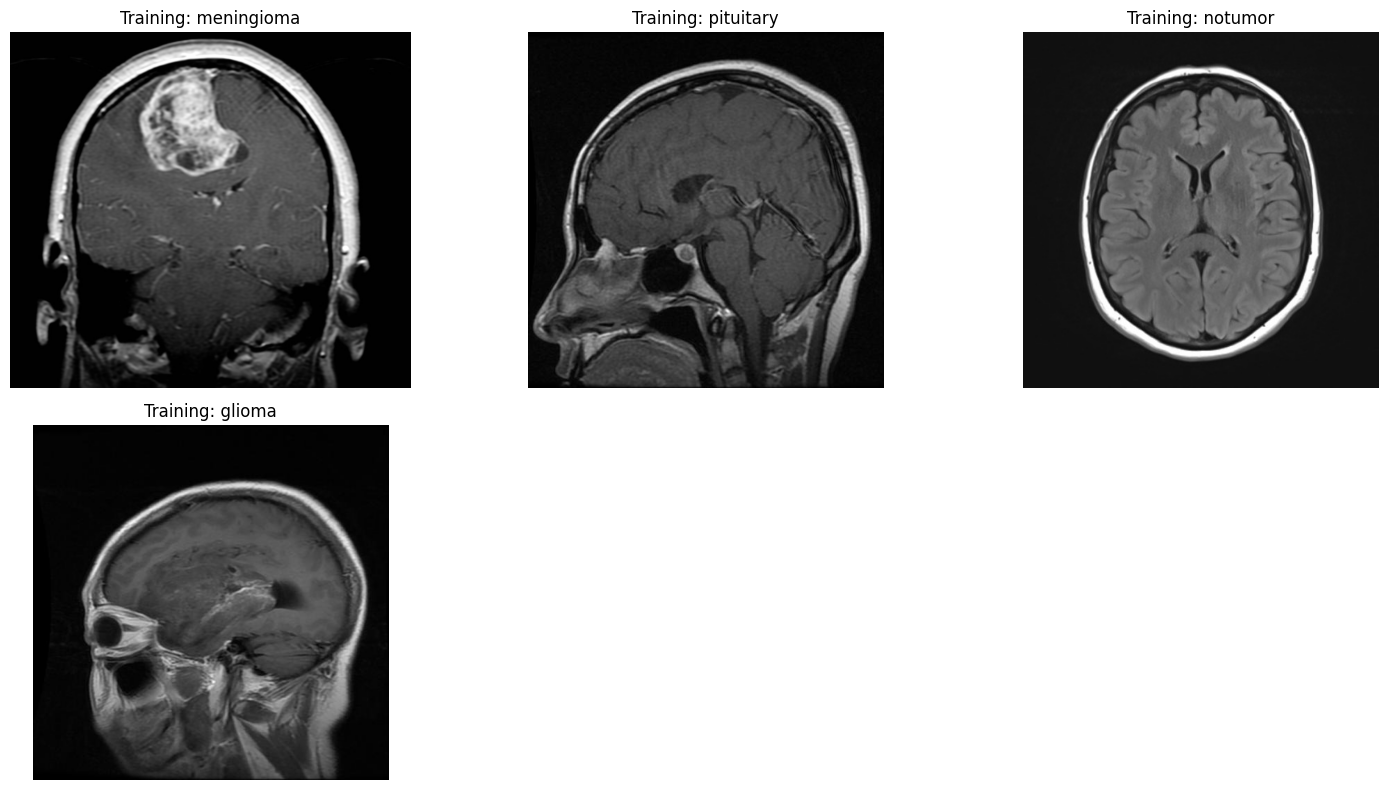

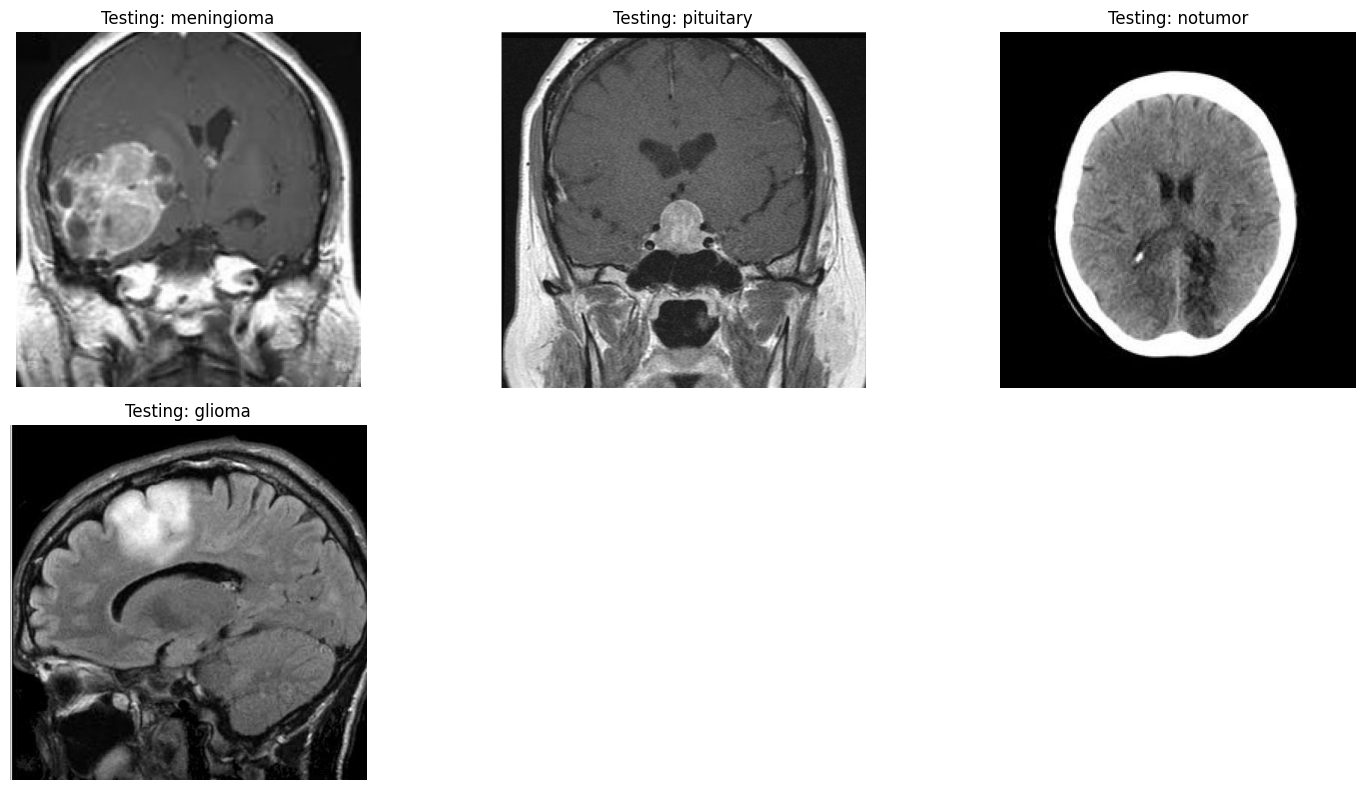

In [40]:
show_sample(df, split='Training')
show_sample(df, split='Testing')

Create a balanced dataset

In [41]:
balanced_df = pd.DataFrame()
target_count = 2500

for cls in df['class'].unique():
    class_df = df[df['class'] == cls]
    sampled_df = class_df.sample(n=target_count, random_state=42)
    balanced_df = pd.concat([balanced_df, sampled_df], ignore_index=True)

# shuffle the final dataframe
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

In [42]:
print("Count by classes in the 2500 images per class dataframe");
print(balanced_df['class'].value_counts())

Count by classes in the 2500 images per class dataframe
class
notumor       2500
pituitary     2500
meningioma    2500
glioma        2500
Name: count, dtype: int64


/tmp/ipykernel_31528/2010379271.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=balanced_df, x='class', palette='pastel')


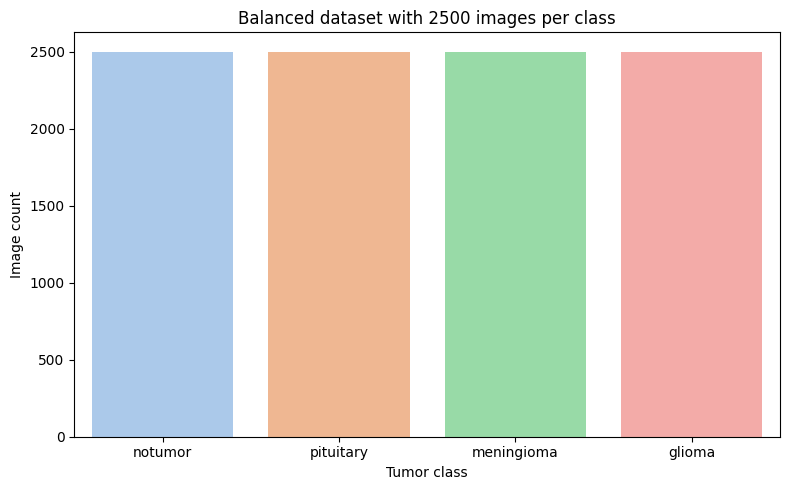

In [43]:
plt.figure(figsize=(8, 5))
sns.countplot(data=balanced_df, x='class', palette='pastel')
plt.title("Balanced dataset with 2500 images per class")
plt.xlabel("Tumor class")
plt.ylabel("Image count")
plt.tight_layout()
plt.show()

Split the data for the balanced dataset

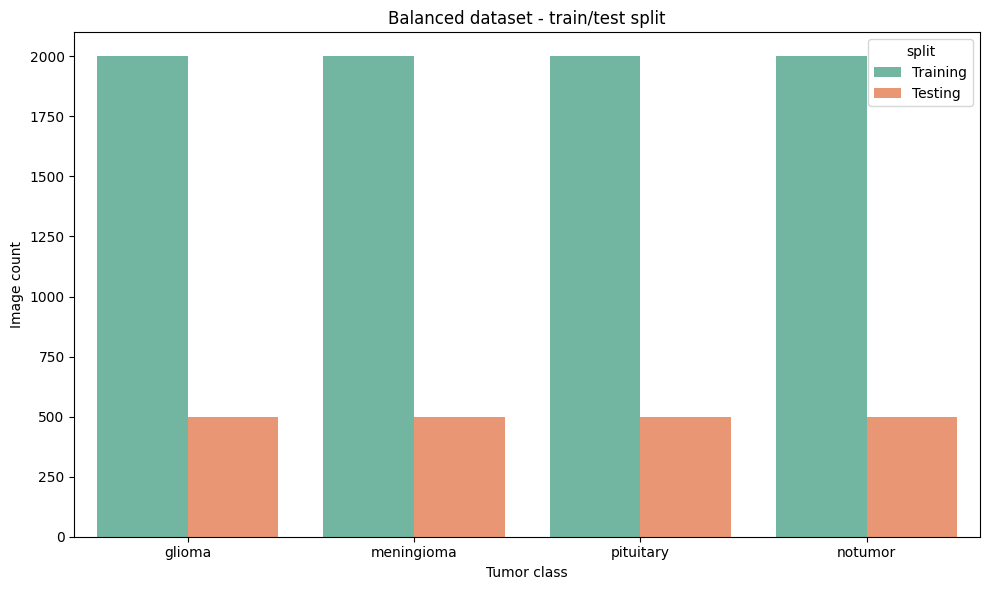

In [44]:
split_balanced = []
class_order = ['glioma', 'meningioma', 'pituitary', 'notumor']
balanced_df['class'] = balanced_df['class'].str.lower()

for cls in class_order:
    class_df = balanced_df[balanced_df['class'] == cls]
    train, test = train_test_split(class_df, test_size=0.2, random_state=42, shuffle=True)
    train = train.copy()
    test = test.copy()
    train['split'] = 'Training'
    test['split'] = 'Testing'
    split_balanced.extend([train, test])

split_df = pd.concat(split_balanced, ignore_index=True)
split_df['class'] = pd.Categorical(split_df['class'], categories = class_order, ordered=True)

plt.figure(figsize=(10, 6))
sns.countplot(data=split_df, x='class', hue='split', palette='Set2')
plt.title("Balanced dataset - train/test split")
plt.xlabel("Tumor class")
plt.ylabel("Image count")
plt.tight_layout()
plt.show()

Compute class weights

In [45]:
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))

Build custom CNN

In [46]:
def build_custom_cnn():
    inputs = Input(shape=(224, 224, 3))
    x = Conv2D(32, (3, 3), activation='relu')(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D()(x)

    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D()(x)

    x = Conv2D(128, (3, 3), activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D()(x)

    x = Dropout(0.4)(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.6)(x)
    outputs = Dense(4, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

Build Transfer Learning Wrapper

In [47]:
def build_transfer_model(base, preprocess):
    base_model = base(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(4, activation='softmax')(x)
    model = Model(inputs=base_model.inputs, outputs=predictions)
    return model

Train the models: CustomCNN, VGG16, MobileNetV2, EfficientNetB0


Training CustomCNN...
Epoch 1/50
258/258 - 72s - loss: 1.0196 - accuracy: 0.6540 - val_loss: 7.7646 - val_accuracy: 0.2852 - lr: 1.0000e-04 - 72s/epoch - 279ms/step
Epoch 2/50
258/258 - 67s - loss: 0.5974 - accuracy: 0.7618 - val_loss: 0.5143 - val_accuracy: 0.7736 - lr: 1.0000e-04 - 67s/epoch - 261ms/step
Epoch 3/50
258/258 - 68s - loss: 0.4682 - accuracy: 0.8110 - val_loss: 0.3057 - val_accuracy: 0.8858 - lr: 1.0000e-04 - 68s/epoch - 263ms/step
Epoch 4/50
258/258 - 67s - loss: 0.3887 - accuracy: 0.8389 - val_loss: 0.2320 - val_accuracy: 0.9276 - lr: 1.0000e-04 - 67s/epoch - 261ms/step
Epoch 5/50
258/258 - 67s - loss: 0.3324 - accuracy: 0.8689 - val_loss: 0.2074 - val_accuracy: 0.9252 - lr: 1.0000e-04 - 67s/epoch - 261ms/step
Epoch 6/50
258/258 - 67s - loss: 0.2833 - accuracy: 0.8824 - val_loss: 0.2684 - val_accuracy: 0.9043 - lr: 1.0000e-04 - 67s/epoch - 261ms/step
Epoch 7/50
258/258 - 67s - loss: 0.2504 - accuracy: 0.8961 - val_loss: 0.1630 - val_accuracy: 0.9383 - lr: 1.0000e-04 -

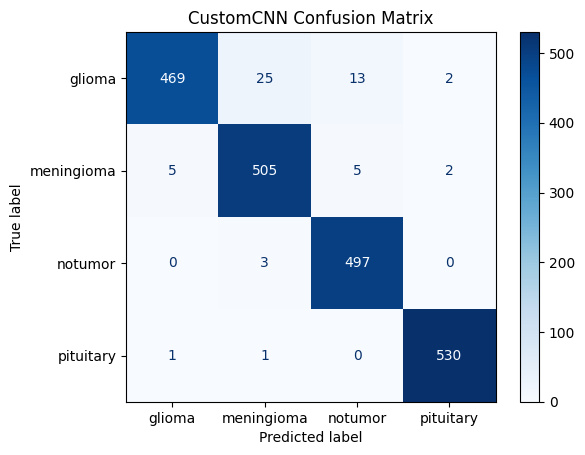


Training VGG16...
Epoch 1/50
258/258 - 278s - loss: 2.9515 - accuracy: 0.4518 - val_loss: 0.7530 - val_accuracy: 0.7119 - lr: 1.0000e-04 - 278s/epoch - 1s/step
Epoch 2/50
258/258 - 277s - loss: 1.0210 - accuracy: 0.6445 - val_loss: 0.5818 - val_accuracy: 0.7741 - lr: 1.0000e-04 - 277s/epoch - 1s/step
Epoch 3/50
258/258 - 277s - loss: 0.7580 - accuracy: 0.7060 - val_loss: 0.4963 - val_accuracy: 0.8168 - lr: 1.0000e-04 - 277s/epoch - 1s/step
Epoch 4/50
258/258 - 275s - loss: 0.6522 - accuracy: 0.7542 - val_loss: 0.4428 - val_accuracy: 0.8465 - lr: 1.0000e-04 - 275s/epoch - 1s/step
Epoch 5/50
258/258 - 283s - loss: 0.5661 - accuracy: 0.7790 - val_loss: 0.4031 - val_accuracy: 0.8620 - lr: 1.0000e-04 - 283s/epoch - 1s/step
Epoch 6/50
258/258 - 276s - loss: 0.5218 - accuracy: 0.8006 - val_loss: 0.3701 - val_accuracy: 0.8727 - lr: 1.0000e-04 - 276s/epoch - 1s/step
Epoch 7/50
258/258 - 276s - loss: 0.4696 - accuracy: 0.8250 - val_loss: 0.3396 - val_accuracy: 0.8868 - lr: 1.0000e-04 - 276s/epo

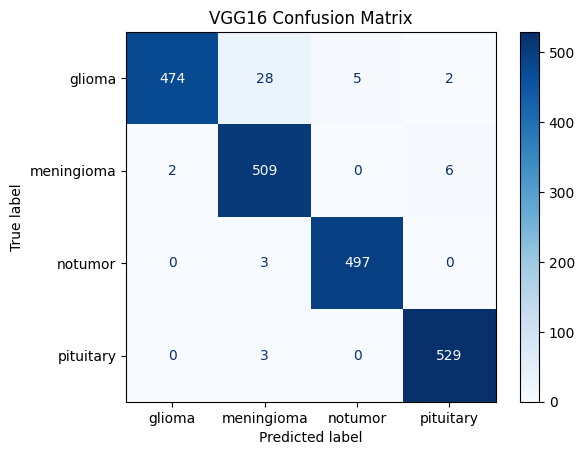


Training MobileNetV2...
Epoch 1/50
258/258 - 33s - loss: 0.8842 - accuracy: 0.6490 - val_loss: 0.5012 - val_accuracy: 0.8348 - lr: 1.0000e-04 - 33s/epoch - 126ms/step
Epoch 2/50
258/258 - 31s - loss: 0.5264 - accuracy: 0.8078 - val_loss: 0.4005 - val_accuracy: 0.8542 - lr: 1.0000e-04 - 31s/epoch - 120ms/step
Epoch 3/50
258/258 - 31s - loss: 0.4257 - accuracy: 0.8425 - val_loss: 0.3334 - val_accuracy: 0.8819 - lr: 1.0000e-04 - 31s/epoch - 121ms/step
Epoch 4/50
258/258 - 31s - loss: 0.3767 - accuracy: 0.8651 - val_loss: 0.3034 - val_accuracy: 0.8897 - lr: 1.0000e-04 - 31s/epoch - 120ms/step
Epoch 5/50
258/258 - 31s - loss: 0.3311 - accuracy: 0.8846 - val_loss: 0.2723 - val_accuracy: 0.9062 - lr: 1.0000e-04 - 31s/epoch - 120ms/step
Epoch 6/50
258/258 - 31s - loss: 0.2973 - accuracy: 0.8971 - val_loss: 0.2497 - val_accuracy: 0.9106 - lr: 1.0000e-04 - 31s/epoch - 120ms/step
Epoch 7/50
258/258 - 31s - loss: 0.2787 - accuracy: 0.9013 - val_loss: 0.2367 - val_accuracy: 0.9155 - lr: 1.0000e-04

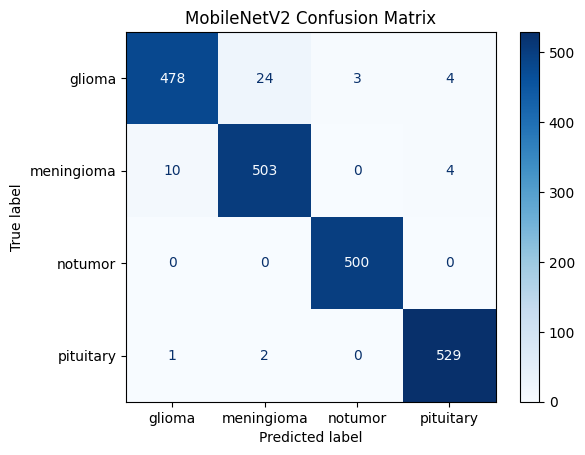


Training EfficientNetB0...
Epoch 1/50
258/258 - 48s - loss: 0.8685 - accuracy: 0.6516 - val_loss: 0.5185 - val_accuracy: 0.8299 - lr: 1.0000e-04 - 48s/epoch - 187ms/step
Epoch 2/50
258/258 - 45s - loss: 0.5527 - accuracy: 0.7944 - val_loss: 0.4070 - val_accuracy: 0.8533 - lr: 1.0000e-04 - 45s/epoch - 174ms/step
Epoch 3/50
258/258 - 45s - loss: 0.4543 - accuracy: 0.8370 - val_loss: 0.3538 - val_accuracy: 0.8727 - lr: 1.0000e-04 - 45s/epoch - 174ms/step
Epoch 4/50
258/258 - 45s - loss: 0.4130 - accuracy: 0.8493 - val_loss: 0.3207 - val_accuracy: 0.8882 - lr: 1.0000e-04 - 45s/epoch - 174ms/step
Epoch 5/50
258/258 - 45s - loss: 0.3737 - accuracy: 0.8638 - val_loss: 0.2934 - val_accuracy: 0.8975 - lr: 1.0000e-04 - 45s/epoch - 175ms/step
Epoch 6/50
258/258 - 45s - loss: 0.3511 - accuracy: 0.8708 - val_loss: 0.2784 - val_accuracy: 0.9018 - lr: 1.0000e-04 - 45s/epoch - 174ms/step
Epoch 7/50
258/258 - 45s - loss: 0.3234 - accuracy: 0.8858 - val_loss: 0.2589 - val_accuracy: 0.9091 - lr: 1.0000e

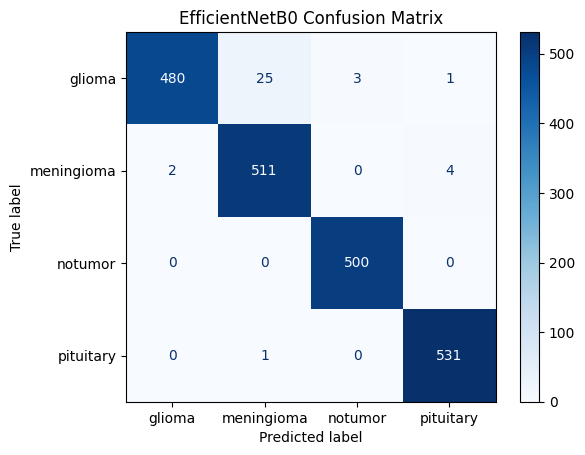

In [48]:
models = {
    "CustomCNN": build_custom_cnn(),
    "VGG16": build_transfer_model(VGG16, vgg16_preprocess),
    "MobileNetV2": build_transfer_model(MobileNetV2, mobilenet_preprocess),
    "EfficientNetB0": build_transfer_model(EfficientNetB0, efficientnet_preprocess)
}

histories = {}
model_preds = {}
model_scores = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

    if name == 'CustomCNN':
        X_train_input = X_train_resized / 255.
        X_val_input = X_val_resized / 255.
    elif name == 'VGG16':
        X_train_input = vgg16_preprocess(X_train_resized.copy())
        X_val_input = vgg16_preprocess(X_val_resized.copy())
    elif name == 'MobileNetV2':
        X_train_input = mobilenet_preprocess(X_train_resized.copy())
        X_val_input = mobilenet_preprocess(X_val_resized.copy())
    elif name == 'EfficientNetB0':
        X_train_input = efficientnet_preprocess(X_train_resized.copy())
        X_val_input = efficientnet_preprocess(X_val_resized.copy())

    history = model.fit(
        X_train_input, y_train_cat,
        validation_data=(X_val_input, y_val_cat),
        epochs=50,
        batch_size=32,
        class_weight=class_weights_dict,
        callbacks=[EarlyStopping(patience=9, restore_best_weights=True), ReduceLROnPlateau(patience=5)],
        verbose=2
    )

    histories[name] = history

    y_pred = model.predict(X_val_input)
    y_pred_classes = np.argmax(y_pred, axis=1)
    acc = np.mean(y_pred_classes == y_val)
    model_preds[name] = y_pred
    model_scores[name] = acc

    print(f"\n{name} Accuracy: {acc * 100:.2f}%")
    print(classification_report(y_val, y_pred_classes, target_names=le.classes_))
    cm = confusion_matrix(y_val, y_pred_classes)
    ConfusionMatrixDisplay(cm, display_labels=le.classes_).plot(cmap='Blues')
    plt.title(f"{name} Confusion Matrix")
    plt.show()

Ensemble prediction (soft voting)


Ensemble Accuracy: 98.64%
              precision    recall  f1-score   support

      glioma       1.00      0.95      0.97       509
  meningioma       0.96      1.00      0.98       517
     notumor       0.99      1.00      0.99       500
   pituitary       1.00      1.00      1.00       532

    accuracy                           0.99      2058
   macro avg       0.99      0.99      0.99      2058
weighted avg       0.99      0.99      0.99      2058



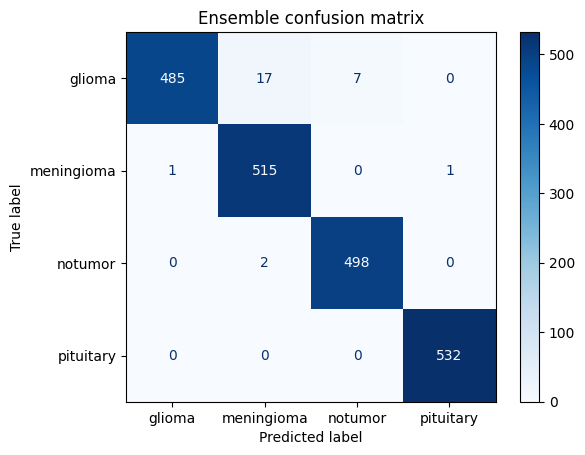

In [49]:
all_preds = np.mean(list(model_preds.values()), axis=0)
y_ensemble = np.argmax(all_preds, axis=1)

ensemble_acc = np.mean(y_ensemble == y_val)
print(f"\nEnsemble Accuracy: {ensemble_acc * 100:.2f}%")
print(classification_report(y_val, y_ensemble, target_names=le.classes_))
cm_ensemble = confusion_matrix(y_val, y_ensemble)
ConfusionMatrixDisplay(cm_ensemble, display_labels=le.classes_).plot(cmap='Blues')
plt.title("Ensemble confusion matrix")
plt.show()

Patch CustomCNN to be called

In [51]:
_ = models["CustomCNN"].predict(np.expand_dims(X_val_resized[0] / 255., axis=0))

1/1 [==============================] - 0s 20ms/step


GRAD-CAM visualization

In [90]:
def guided_backprop(model, image, label_index, preprocess=None):
    img_tensor = np.expand_dims(image, axis=0).astype(np.float32)
    if preprocess:
        img_tensor = preprocess(img_tensor.copy())
    else:
        img_tensor = img_tensor / 255.0

    img_tensor = tf.convert_to_tensor(img_tensor, dtype=tf.float32)

    @tf.custom_gradient
    def guided_relu(x):
        def grad(dy):
            return tf.cast(dy > 0, "float32") * tf.cast(x > 0, "float32") * dy
        return tf.nn.relu(x), grad

    layer_dict = [layer for layer in model.layers if hasattr(layer, 'activation')]
    for layer in layer_dict:
        if layer.activation == tf.keras.activations.relu:
            layer.activation = guided_relu

    with tf.GradientTape() as tape:
        tape.watch(img_tensor)
        preds = model(img_tensor, training=False)
        loss = preds[:, label_index]

    grads = tape.gradient(loss, img_tensor)[0]
    guided_grads = tf.cast(grads > 0, "float32") * tf.cast(img_tensor > 0, "float32") * grads
    guided_grads = tf.reduce_mean(guided_grads, axis=-1)  # Ensure single channel
    guided_grads = tf.squeeze(guided_grads)  # Remove any extra dimensions
    guided_grads = cv2.resize(guided_grads.numpy(), (224, 224))
    return guided_grads

def generate_grad_cam(model, image, label_index, preprocess=None):
    img_tensor = np.expand_dims(image, axis=0).astype(np.float32)
    if preprocess:
        img_tensor = preprocess(img_tensor.copy())
    else:
        img_tensor = img_tensor / 255.0

    last_conv_layer = None
    for layer in reversed(model.layers):
        if isinstance(layer, tf.keras.layers.Conv2D):
            last_conv_layer = layer.name
            break

    grad_model = Model([model.inputs], [model.get_layer(last_conv_layer).output, model.output])
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_tensor)
        loss = predictions[:, label_index]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    heatmap = np.maximum(heatmap, 0) / tf.math.reduce_max(heatmap + tf.keras.backend.epsilon())
    heatmap = cv2.resize(heatmap.numpy(), (224, 224))
    return heatmap

def overlay_heatmap(heatmap, image, guided_grads=None):
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    if guided_grads is not None:
        if len(guided_grads.shape) > 2:
            guided_grads = guided_grads[..., 0] 
        guided_grads_normalized = cv2.normalize(guided_grads, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
        guided_grads_colored = cv2.applyColorMap(guided_grads_normalized, cv2.COLORMAP_JET)
        heatmap_colored = cv2.addWeighted(heatmap_colored, 0.7, guided_grads_colored, 0.3, 0)
    superimposed_img = cv2.addWeighted(image.astype(np.uint8), 0.6, heatmap_colored, 0.4, 0)
    return superimposed_img

1/1 [==============================] - 0s 28ms/step


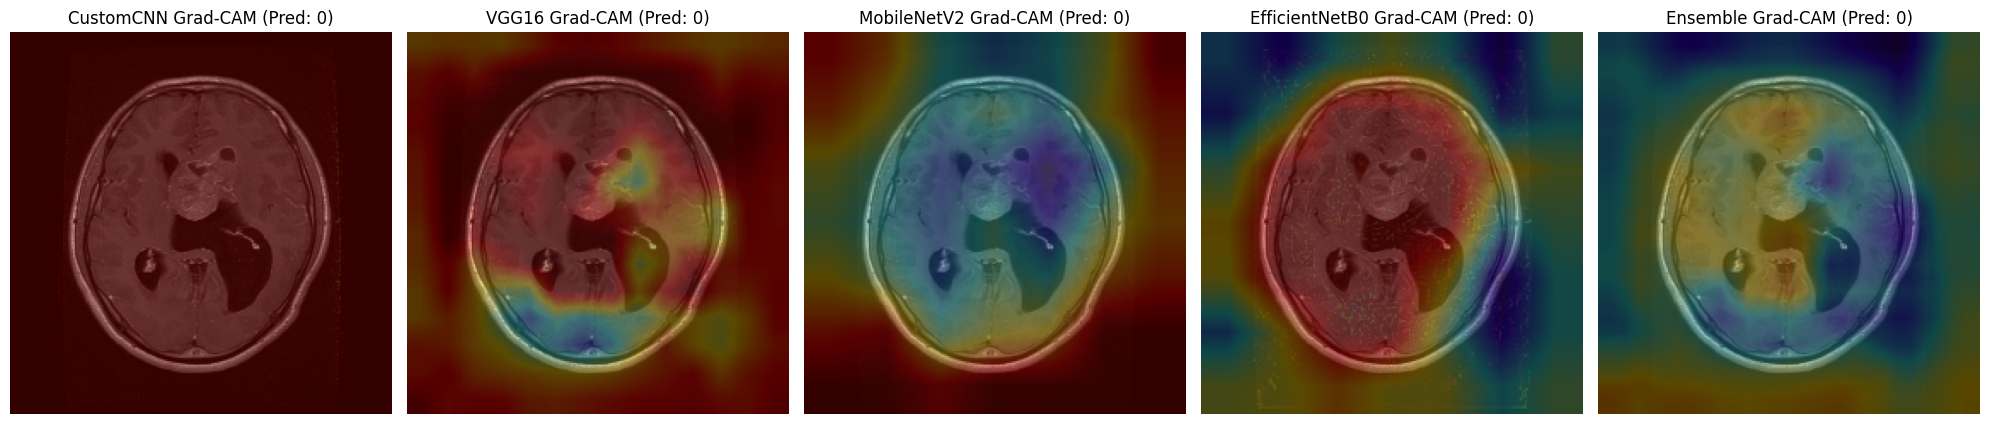

In [93]:
preprocessors = {
    "CustomCNN": None,
    "VGG16": vgg16_preprocess,
    "MobileNetV2": mobilenet_preprocess,
    "EfficientNetB0": efficientnet_preprocess,
    "Ensemble": efficientnet_preprocess
}

sample_img = X_val_resized[1]

heatmaps = {}
guided_grads = {}
predictions = {}
for name, model in models.items():
    img_tensor = np.expand_dims(sample_img, axis=0).astype(np.float32)
    if preprocessors[name]:
        img_tensor = preprocessors[name](img_tensor.copy())
    else:
        img_tensor = img_tensor / 255.0
    pred = model.predict(img_tensor)
    predicted_label = np.argmax(pred)
    predictions[name] = predicted_label
    heatmap = generate_grad_cam(model, sample_img, predicted_label, preprocess=preprocessors[name])
    guided_grad = guided_backprop(model, sample_img, predicted_label, preprocess=preprocessors[name])
    heatmaps[name] = heatmap
    guided_grads[name] = guided_grad

ensemble_preds = np.mean([models[name].predict(np.expand_dims(sample_img, axis=0).astype(np.float32) if not preprocessors[name] else preprocessors[name](np.expand_dims(sample_img, axis=0).astype(np.float32))) for name in models], axis=0)
ensemble_label = np.argmax(ensemble_preds)
confidences = [pred.max() for pred in [models[name].predict(np.expand_dims(sample_img, axis=0).astype(np.float32) if not preprocessors[name] else preprocessors[name](np.expand_dims(sample_img, axis=0).astype(np.float32))) for name in models]]
ensemble_heatmap = np.average(list(heatmaps.values()), weights=confidences, axis=0)
ensemble_heatmap = np.maximum(ensemble_heatmap, 0) / np.max(ensemble_heatmap)
ensemble_guided_grad = np.average(list(guided_grads.values()), weights=confidences, axis=0)

plt.figure(figsize=(20, 8))
for i, (name, model) in enumerate(models.items()):
    grad_cam_img = overlay_heatmap(heatmaps[name], sample_img, guided_grads[name])
    plt.subplot(1, 5, i + 1)
    plt.imshow(grad_cam_img)
    plt.title(f"{name} Grad-CAM (Pred: {predictions[name]})")
    plt.axis('off')

ensemble_grad_cam_img = overlay_heatmap(ensemble_heatmap, sample_img, ensemble_guided_grad)
plt.subplot(1, 5, 5)
plt.imshow(ensemble_grad_cam_img)
plt.title(f"Ensemble Grad-CAM (Pred: {ensemble_label})")
plt.axis('off')

plt.tight_layout()
plt.show()

Save the best model

In [74]:
best_model_name = max(model_scores, key=model_scores.get)
print(f"\nBest Model: {best_model_name} with Accuracy: {model_scores[best_model_name] * 100:.2f}%")
models[best_model_name].save(f"best_model_{best_model_name}.h5")


Best Model: EfficientNetB0 with Accuracy: 98.25%


Display all accuracies

In [75]:
print("\nAccuracies:")
for model_name, score in model_scores.items():
    print(f"{model_name}: {score * 100:.2f}%")
print(f"Ensemble: {ensemble_acc * 100:.2f}%")


Accuracies:
CustomCNN: 97.23%
VGG16: 97.62%
MobileNetV2: 97.67%
EfficientNetB0: 98.25%
Ensemble: 98.64%


Accuracy and loss curves

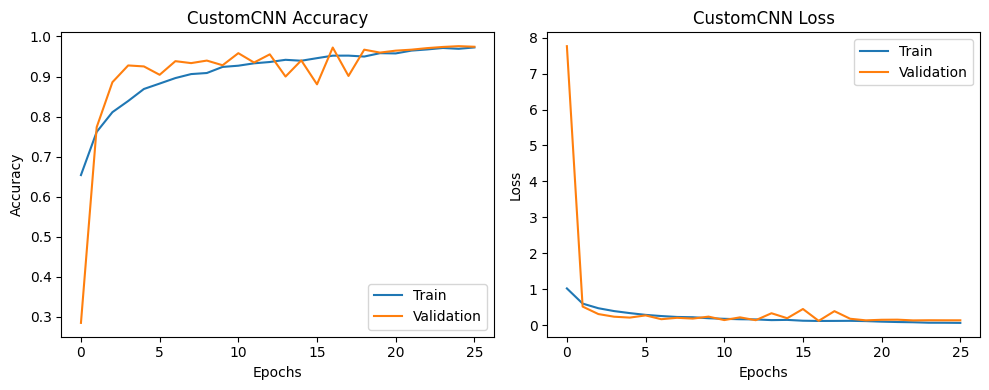

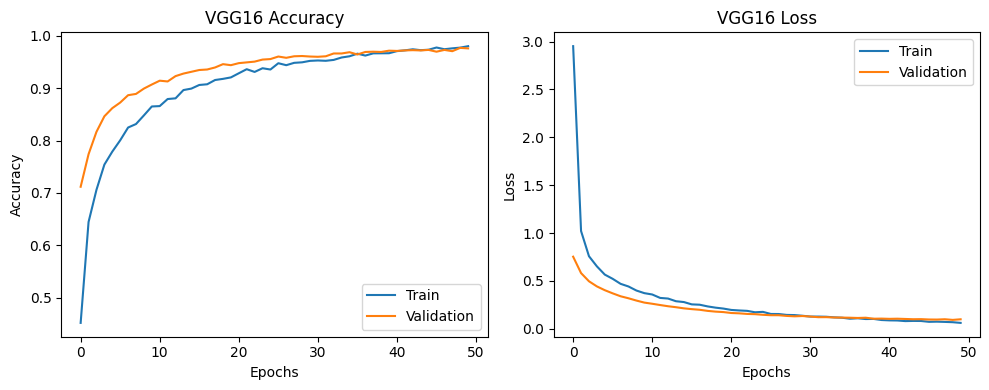

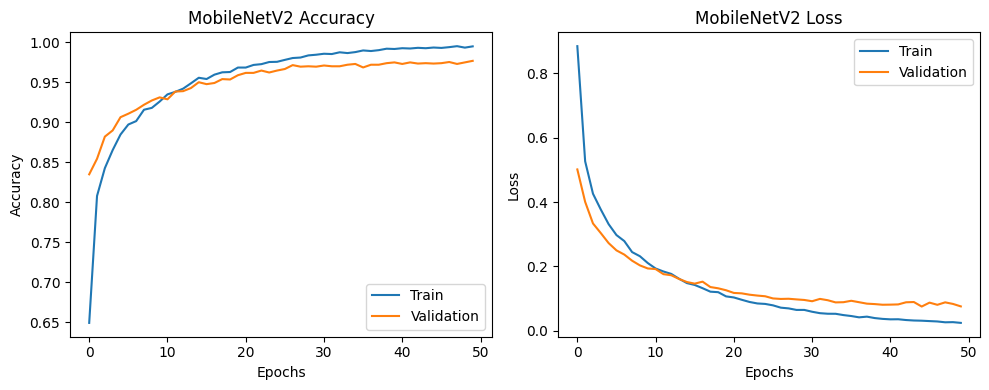

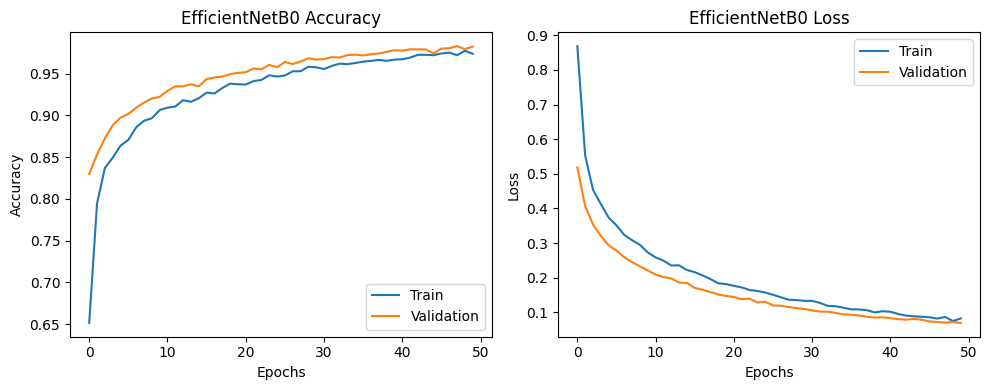

In [76]:
for name, history in histories.items():
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.title(f'{name} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title(f'{name} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()

Validation accuracy and loss across models

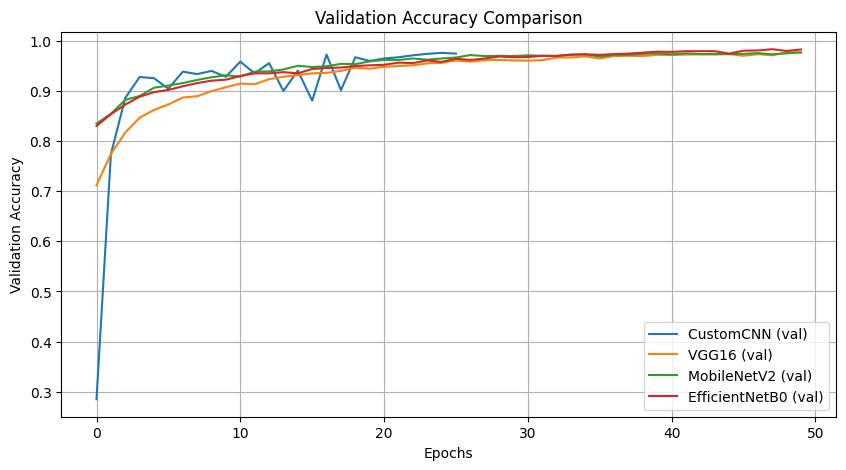

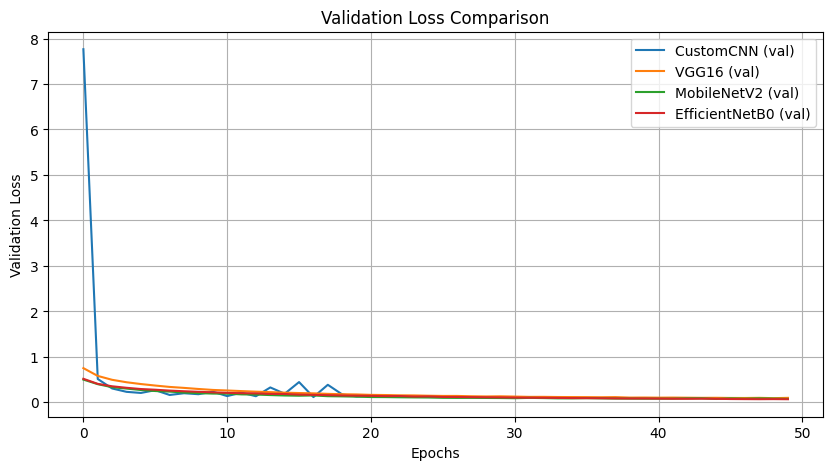

In [85]:
plt.figure(figsize=(10, 5))
for name, history in histories.items():
    if 'val_accuracy' in history.history:
        plt.plot(history.history['val_accuracy'], label=f'{name} (val)')
plt.title('Validation Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
for name, history in histories.items():
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label=f'{name} (val)')
plt.title('Validation Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


Training accuracy and loss across models

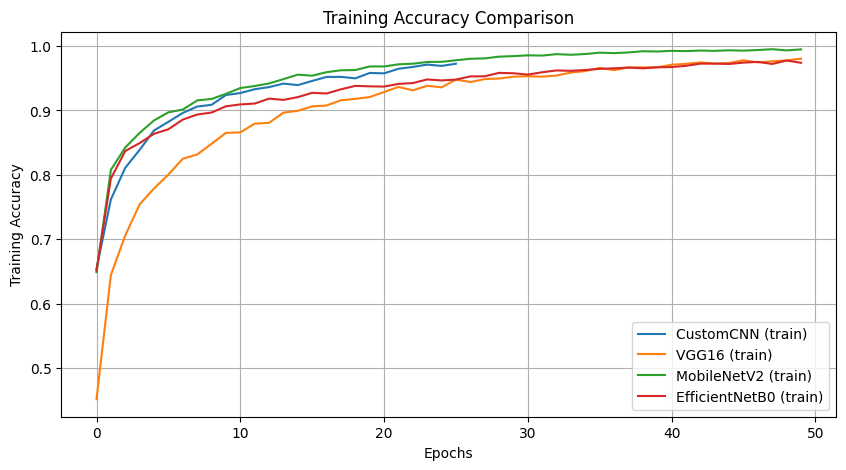

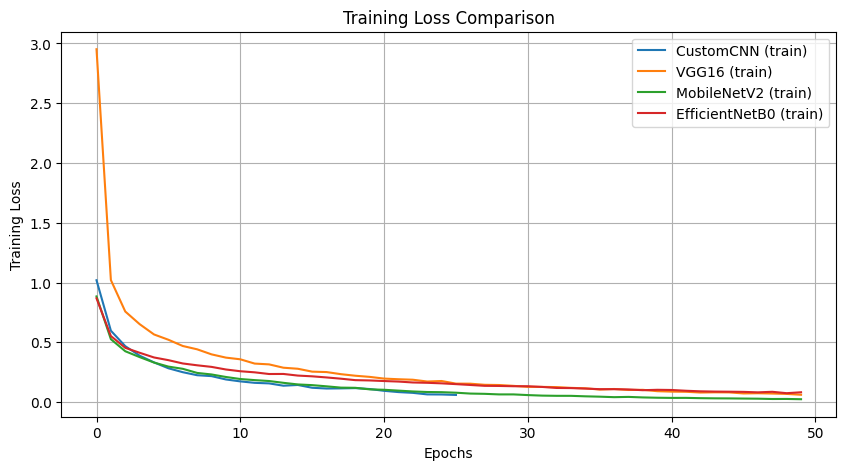

In [86]:
plt.figure(figsize=(10, 5))
for name, history in histories.items():
    if 'accuracy' in history.history:
        plt.plot(history.history['accuracy'], label=f'{name} (train)')
plt.title('Training Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Training Accuracy')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
for name, history in histories.items():
    if 'loss' in history.history:
        plt.plot(history.history['loss'], label=f'{name} (train)')
plt.title('Training Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.legend()
plt.grid(True)
plt.show()

Accuracy and loss curves (training vs validation)

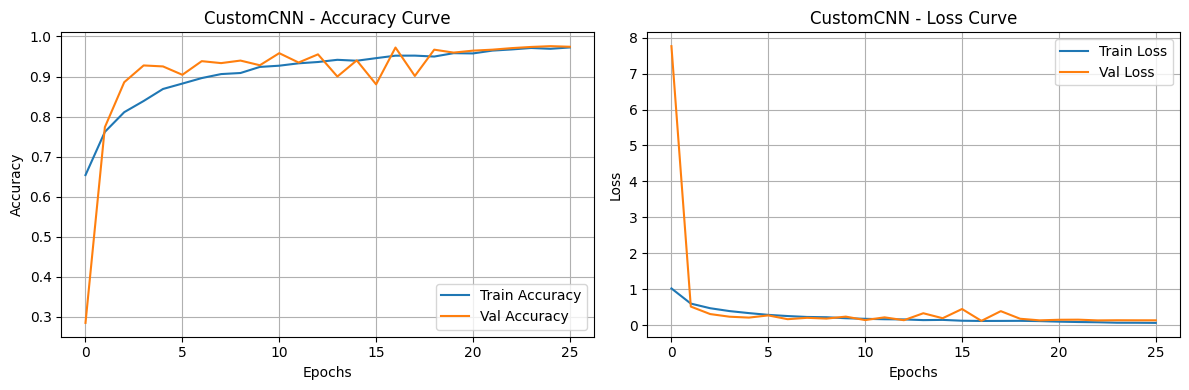

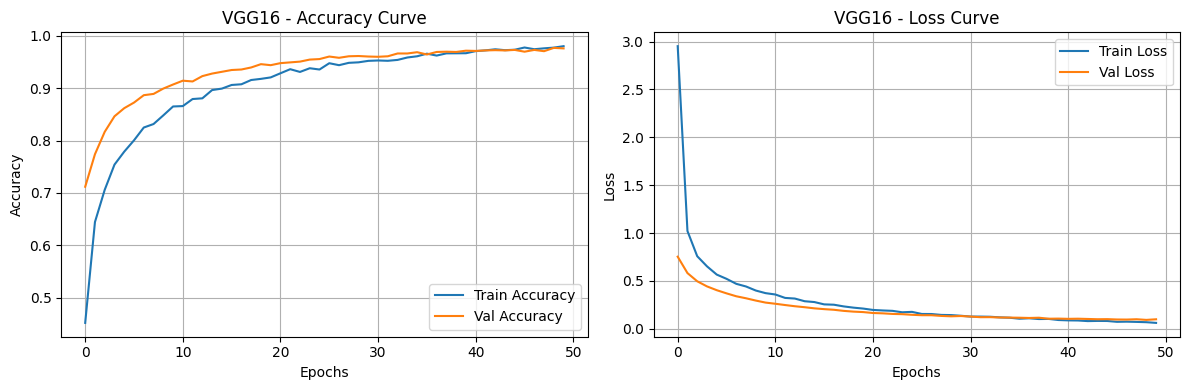

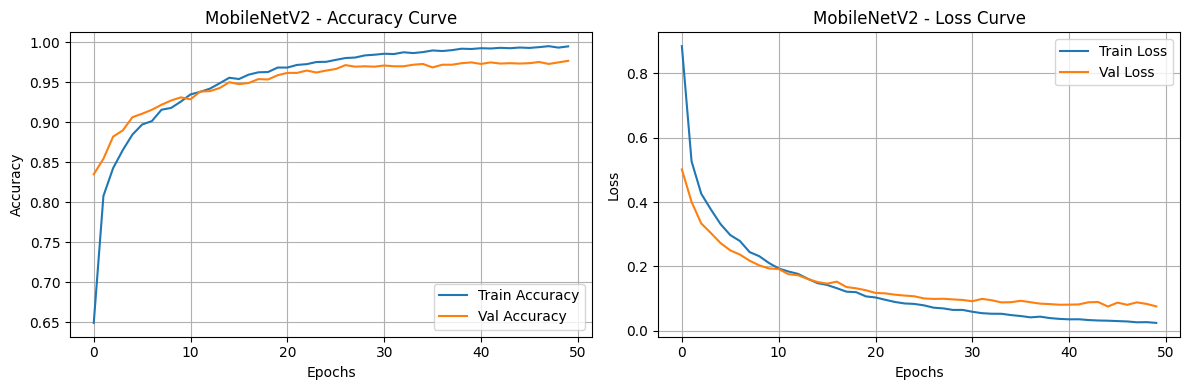

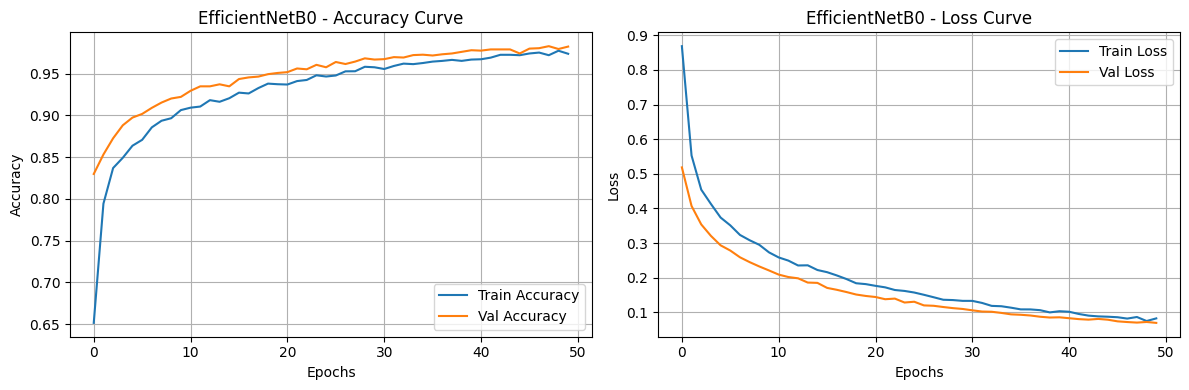

In [87]:
for name, history in histories.items():
    acc = history.history.get('accuracy', [])
    val_acc = history.history.get('val_accuracy', [])
    loss = history.history.get('loss', [])
    val_loss = history.history.get('val_loss', [])

    if acc and val_acc:
        plt.figure(figsize=(12, 4))

        # Accuracy plot
        plt.subplot(1, 2, 1)
        plt.plot(acc, label='Train Accuracy')
        plt.plot(val_acc, label='Val Accuracy')
        plt.title(f'{name} - Accuracy Curve')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True)

        # Loss plot
        plt.subplot(1, 2, 2)
        plt.plot(loss, label='Train Loss')
        plt.plot(val_loss, label='Val Loss')
        plt.title(f'{name} - Loss Curve')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.show()

Performance comparison between models (table)

In [88]:
metrics_table = []

for name, preds in model_preds.items():
    y_pred_labels = np.argmax(preds, axis=1)
    acc = accuracy_score(y_val, y_pred_labels)
    prec = precision_score(y_val, y_pred_labels, average='macro')
    rec = recall_score(y_val, y_pred_labels, average='macro')
    f1 = f1_score(y_val, y_pred_labels, average='macro')
    metrics_table.append([name, acc, prec, rec, f1])

# Add Ensemble
ensemble_preds = np.argmax(np.mean(list(model_preds.values()), axis=0), axis=1)
ensemble_acc = accuracy_score(y_val, ensemble_preds)
ensemble_prec = precision_score(y_val, ensemble_preds, average='macro')
ensemble_rec = recall_score(y_val, ensemble_preds, average='macro')
ensemble_f1 = f1_score(y_val, ensemble_preds, average='macro')
metrics_table.append(["Ensemble", ensemble_acc, ensemble_prec, ensemble_rec, ensemble_f1])

# Create DataFrame
df_metrics = pd.DataFrame(metrics_table, columns=["Model", "Accuracy", "Precision", "Recall", "F1-Score"])
df_metrics = df_metrics.sort_values("Accuracy", ascending=False)
print(df_metrics)

            Model  Accuracy  Precision    Recall  F1-Score
4        Ensemble  0.986395   0.986656  0.986245  0.986250
3  EfficientNetB0  0.982507   0.983035  0.982385  0.982437
2     MobileNetV2  0.976676   0.976873  0.976594  0.976598
1           VGG16  0.976190   0.977081  0.976031  0.976135
0       CustomCNN  0.972303   0.972655  0.972111  0.971981


Performance comparison between models (bar plot)

/tmp/ipykernel_31528/2143413064.py:8: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()
/home/lateral/miniconda3/envs/py311/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


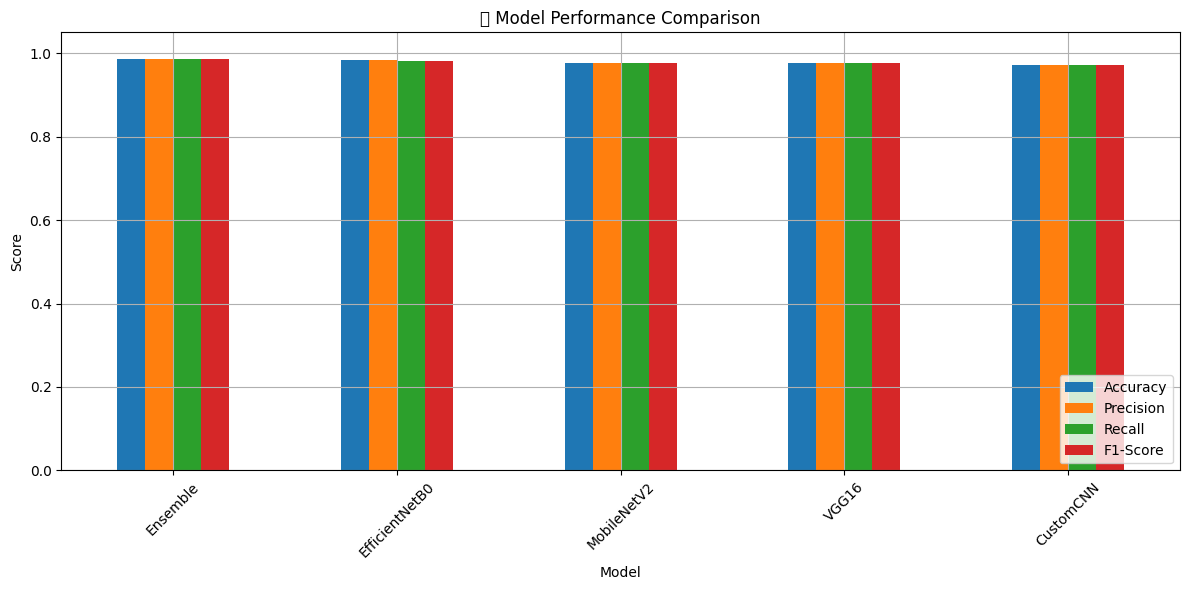

In [89]:
df_metrics.set_index("Model")[["Accuracy", "Precision", "Recall", "F1-Score"]].plot(kind="bar", figsize=(12, 6))
plt.title("📊 Model Performance Comparison")
plt.ylabel("Score")
plt.ylim(0, 1.05)
plt.grid(True)
plt.xticks(rotation=45)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()
